In [1]:
import time
from datetime import datetime
import argparse
import json
import threading
import queue
import os
import glob

import cv2
import numpy as np
import torch
# import redis
import matplotlib.pyplot as plt

from core import support, share_param
from insight_face.modules.tracking.custom_tracking import TrackingMultiCam
from insight_face.utils.database import FaceRecognitionSystem
from insight_face.modules.evalution.custom_evaluter import CustomEvaluter

In [33]:
share_param.sdk_config = support.get_config_yaml("configs/sdk_config.yaml")
share_param.dev_config = support.get_config_yaml("configs/dev_config.yaml")
share_param.facerec_system = FaceRecognitionSystem(share_param.dev_config["DATA"]["photo_path"], share_param.sdk_config )
share_param.cam_infos = support.get_config_yaml("configs/cam_infos.yaml") 

Start SDK initialization.
Using cache found in /home/khiem/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-8-12 torch 1.9.0 CUDA:0 (GeForce GTX 1050 Ti, 4040.0625MB)

Fusing layers... 
Model Summary: 224 layers, 7059304 parameters, 0 gradients, 16.3 GFLOPs
Adding AutoShape... 
Finish SDK initialization


['mask', 'glasses', 'hand']


In [35]:
%matplotlib inline

for filename in glob.glob("/mnt/EXT4_DATA/LienVietTech/Data/showroom_check_quality/0pass/*.jpg"):
    bgr = cv2.imread(filename)
    # bgr = bgr[bgr.shape[0]//5: bgr.shape[0] - bgr.shape[0]//5, bgr.shape[1]//5: bgr.shape[1] - bgr.shape[1]//5]
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    # preTime = time.time()
    bboxes, landmarks = share_param.facerec_system.sdk.detect_post_faces(rgb)
    # print("Detect", time.time() - preTime)
    # print(bboxes_batch)

    bgrDraw = bgr.copy()

    for bbox, landmark in zip(bboxes, landmarks):
        cv2.rectangle(bgrDraw, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
        y = bbox[1] - 15 if bbox[1] - 15 > 15 else bbox[1] + 15
        cv2.putText(bgrDraw, "{:03.3f}".format(bbox[4]), (int(bbox[0]), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
        cnts = landmark.reshape(5,2, order='F').astype(np.int16)
        for point in cnts:
            # print(point)
            cv2.drawMarker(bgrDraw, tuple(point), color=(0,255,0), markerType=cv2.MARKER_CROSS, markerSize=8, thickness=2)
        
    if len(bboxes) > 0:
        name = os.path.basename(filename)
        cv2.imwrite(f"datalab/pass/0.7_hasface/{name}", bgrDraw)
    else:
        name = os.path.basename(filename)
        cv2.imwrite(f"datalab/pass/0.7_noface/{name}", bgrDraw)
    # plt.imshow(bgrDraw)
# plt.show()


In [ ]:
#CROP
count = 0
for root, dirs, files in os.walk("/mnt/LINUXDATA/Source/.data/face_attributes/mask02", topdown=False):
    # print(root)
    for name in files:
        count+=1
        path = os.path.join(root, name)
        bgr = cv2.imread(path)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        bboxes, landmarks = share_param.facerec_system.sdk.detect_faces(rgb)
        # print(bboxes)
        # print(landmarks)
        for bbox, landmark in zip(bboxes, landmarks):
            faceW = bbox[2] - bbox[0]
            faceH = bbox[3] - bbox[1]
            expandLeft = max(0, bbox[0] - faceW/3)
            expandTop = max(0, bbox[1] - faceH/3)
            expandRight = min(bbox[2] + faceW/3, bgr.shape[1])
            expandBottom = min(bbox[3] + faceH/3, bgr.shape[0])
            faceCropExpand = bgr[int(expandTop):int(expandBottom), int(expandLeft):int(expandRight)].copy()
            cv2.imwrite(f"dataset/mask02/{count:04d}.jpg", faceCropExpand)


### Check quality
Blur and Straight

In [ ]:

%matplotlib inline
count = 0

for cam_info in share_param.cam_infos["CamInfos"]:
    deviceID = cam_info["DeviceID"]
    camURL = cam_info["LinkRTSP"]

    evalution_config = share_param.sdk_config["evaluter"]
    evalution_config["illumination_threshold"] = cam_info["illumination_threshold"]
    evalution_config["blur_threshold"] = cam_info["blur_threshold"]
    share_param.evaluter_cams[deviceID] = CustomEvaluter(evalution_config)

for root, dirs, files in os.walk("datalab/good", topdown=False):
    print(root)
    for name in files:
        count+=1
        if count>100:
            break
        # print(name)
        # if name != "focus_02550.jpg":
        #     continue
        path = os.path.join(root, name)
        bgr = cv2.imread(path)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        bboxes, landmarks = share_param.facerec_system.sdk.detect_faces(rgb)
        # print(bboxes)
        # print(landmarks)
        for bbox, landmark in zip(bboxes, landmarks):
            faceSize = float((bbox[3]-bbox[1])*(bbox[2]-bbox[0]))
            faceAlign = share_param.facerec_system.sdk.align_face(rgb, landmark)
            faceCrop = rgb[int(bbox[1]):int(bbox[3]),
                                    int(bbox[0]):int(bbox[2])]

            if faceCrop.shape[0] < 50 or faceCrop.shape[1] < 50:
                continue

            faceCrop = rgb[rgb.shape[0]//5: rgb.shape[0] - rgb.shape[0]//5, rgb.shape[1]//5: rgb.shape[1] - rgb.shape[1]//5]
            # isillumination, threshillumination = share_param.facerec_system.sdk.evaluter.check_illumination(faceCrop)
            # isNotBlur, threshnotblur = share_param.facerec_system.sdk.evaluter.check_not_blur(faceCrop)
            # isStraightFace = share_param.facerec_system.sdk.evaluter.check_straight_face(rgb, landmark)

            isillumination, threshillumination = share_param.evaluter_cams[1].check_illumination(faceCrop)
            isNotBlur, threshnotblur = share_param.evaluter_cams[1].check_not_blur(faceCrop)


            # isNotBlur, threshnotblur = share_param.facerec_system.sdk.evaluter.check_not_blur(faceCrop)
            # illuminate = share_param.facerec_system.sdk.evaluter.check_illumination(faceCrop)
            # isNotBlur, threshnotblur = share_param.facerec_system.sdk.evaluter.detect_blur_fft(faceAlign, size=30)
            # isStraightFace = share_param.facerec_system.sdk.evaluter.check_straight_face(rgb, landmark)
            # print("Not blur:", isNotBlur)
            # print("Straight:", isStraightFace)
            # cnts = landmark.reshape(5,2, order='F')
            # for point in cnts:
            #     cv2.drawMarker(rgb, tuple(point), color=(0,255,0), markerType=cv2.MARKER_CROSS, markerSize=8, thickness=1)
            # cv2.putText()
            plt.figure()
            plt.title(f"{name} {threshnotblur}")
            # cv2.putText(image, text, org, font, fontScale, color[, thickness[, lineType[, bottomLeftOrigin]]])
            cv2.putText(bgr, "{:03.3f}".format(threshnotblur), (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            new_path = os.path.join(root, "blur_"+ name)
            cv2.imwrite(new_path, bgr)

            plt.imshow(faceCrop)


            # plt.show()

0.015360116958618164


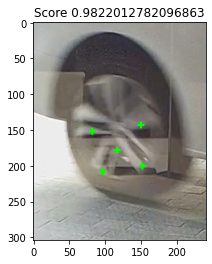

In [28]:
%matplotlib inline
#Check similar
face_desc = {}
for root, dirs, files in os.walk("datalab/similar", topdown=False):
    files.sort()
    for name in files:
        path = os.path.join(root, name)
        bgr = cv2.imread(path)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        # plt.imshow(rgb)

        try:
            preTime = time.time()
            bboxes, landmarks = share_param.facerec_system.sdk.detect_post_faces(rgb)
            print(time.time() - preTime)
            if len(bboxes) > 1:
                raise ValueError("Detected more than one face on provided image.")
            elif len(bboxes) == 0:
                raise ValueError("Can't detect any faces on provided image.")

            cnts = landmarks[0].reshape(5,2, order='F').astype(np.int16)
            for point in cnts:
                cv2.drawMarker(rgb, tuple(point), color=(0,255,0), markerType=cv2.MARKER_CROSS, markerSize=8, thickness=2)

            face = share_param.facerec_system.sdk.align_face(rgb, landmarks[0])
            descriptor = share_param.facerec_system.sdk.get_descriptor(face)
            plt.figure()
            strInfo = f"Score {bboxes[0][4]}"
            plt.title(strInfo)
            plt.imshow(rgb)
        except:
            continue
        face_desc[name] = descriptor

In [ ]:
%matplotlib inline

background = cv2.imread("datalab/background.png")

for root, dirs, files in os.walk("datalab/similar", topdown=False):
    for name in files:
        path = os.path.join(root, name)
        bgr = cv2.imread(path)

        newbackground = background.copy()

        newbackground[400:400+bgr.shape[0], 400:400+bgr.shape[1]] = bgr

        bgrDraw = newbackground.copy()

        rgb = cv2.cvtColor(newbackground, cv2.COLOR_BGR2RGB)
        bboxes_batch, landmarks_batch = share_param.facerec_system.sdk.detect_faces_batch([rgb])

        # bgrDraw = bgr.copy()

        for bboxes, landmarks in zip(bboxes_batch, landmarks_batch):
            for bbox, landmark in zip(bboxes, landmarks):
                cv2.rectangle(bgrDraw, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
                y = bbox[1] - 15 if bbox[1] - 15 > 15 else bbox[1] + 15
                cv2.putText(bgrDraw, "{:03.3f}".format(bbox[4]), (int(bbox[0]), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
                cnts = landmark.reshape(5,2, order='F').astype(np.int16)
                for point in cnts:
                    cv2.drawMarker(bgrDraw, tuple(point), color=(0,255,0), markerType=cv2.MARKER_CROSS, markerSize=8, thickness=2)
        cv2.imwrite("datalab/output/" + name, bgrDraw)
        plt.imshow(bgrDraw)

In [ ]:
import csv
with open('names.csv', 'w', newline='') as csvfile:
    fieldnames = ['name'] + list(face_desc)
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()

    for cur_desc in face_desc:
        row_simi = {'name': cur_desc}
        for another_desc in face_desc:
            simi = share_param.facerec_system.sdk.get_similarity(face_desc[cur_desc], face_desc[another_desc])
            row_simi[another_desc] = f"{simi:03.2f}"

        writer.writerow(row_simi)

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

img = cv2.imread('datalab/images/20210507145554353919.jpg')
# img = cv2.resize(img, (224,224))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


In [ ]:

minsize = 20 # minimum size of face
threshold = [ 0.6, 0.7, 0.7 ]  # three steps's threshold
factor = 0.709 # scale factor

#Size Parameter
lower_threshold = 100
upper_threshold = 200

bboxes, points = share_param.facerec_system.sdk.detect_faces(img)

print(bboxes, points)


In [ ]:
def illumination(gray):
    # length of R available  range  of  gray  intensities  excluding  5%  of  the darkest  and  brightest  pixel
    sorted_gray = np.sort(gray.ravel())
    l = len(sorted_gray)
    cut_off_idx = l * 5 // 100
    r = sorted_gray[l-cut_off_idx] - sorted_gray[cut_off_idx]
    return np.round(r / 255, 2)


In [ ]:
illumination(gray)

In [ ]:
def get_contour(pts):
    return np.array([[pts[i], pts[5 + i]] for i in  [0, 1, 4, 3]], np.int32).reshape((-1,1,2))
def get_mask(image, contour):
    mask = np.zeros(image.shape[0:2],dtype="uint8")
    cv2.drawContours(mask, [contour], -1, 255, -1)
    return mask

In [ ]:
def sharpness(img, landmark):
    contour = get_contour(landmark)
    mask = get_mask(img, contour) #1-channel mask
    # plt.imshow(mask)
    mask = np.stack((mask,)*3, axis=-1) #3-channel mask
    mask[mask == 255] = 1 # convert 0 and 255 to 0 and 1
    laplacian = cv2.Laplacian(img,cv2.CV_64F)
    # print(laplacian)
    # print(laplacian.var())
    edges = laplacian[mask.astype(bool)]
    return np.round(edges.var() / 255 , 2)

plt.imshow(img)
sharpness(img, points[0])

In [ ]:
from skimage.feature import hog

def symmetry(img, landmark, bounding_box):
    x1, y1, x2, y2 = int(min(bounding_box[0], min(landmark[:5]))), \
        int(min(bounding_box[1], min(landmark[5:]))), \
        int(max(bounding_box[2], max(landmark[:5]))), \
        int(max(bounding_box[3], max(landmark[5:])))
    
    landmark = np.array([[landmark[i], landmark[5 + i]] for i in  range(5)], np.int32).reshape((-1,1,2))
    contour = landmark[:, 0] - [[x1, y1]]
    
    face = img[y1: y2, x1: x2].copy()
    face_flip = cv2.flip(face, 1)
    
    fd_face, hog_face = hog(face, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    fd_flip, hog_flip = hog(face_flip, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    
    
    d = np.zeros(len(contour))
    for i in range(len(d)):
        d[i] = min(hog_face[contour[i, 1], contour[i, 0]], hog_flip[contour[i, 1], contour[i, 0]])
    
    return np.average(d)

In [ ]:
symmetry(img, points[0], bboxes[0])

In [ ]:
plt.figure()
for root, dirs, files in os.walk("datalab/images/", topdown=False):
    # print(root)
    for name in files:
        path = os.path.join(root, name)
        img = cv2.imread(path)
        # img = cv2.resize(img, (224,224))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        bboxes, points = share_param.facerec_system.sdk.detect_faces(img)
        if len(bboxes) == 0:
            continue
        # print(bboxes)
        # print(points)
        # print("illumination",illumination(gray))
        # print("sharpness",sharpness(img, points[0]))
        # print("symmetry", symmetry(img, points[0], bboxes[0]))

        cv2.rectangle(img, (int(bboxes[0][0]), int(bboxes[0][1])), (int(bboxes[0][2]), int(bboxes[0][3])), (0, 255, 0), 2)
        plt.figure()
        strInfo = f"{illumination(gray)} {sharpness(img, points[0])} {symmetry(img, points[0], bboxes[0])}"
        plt.title(strInfo)
        plt.imshow(img)



In [ ]:
sharpness 0.27
symmetry 0.11464042663574218

### TEST CARD ID

In [ ]:
import time
from datetime import datetime
import argparse
import json
import threading
import queue
import os

import cv2
import numpy as np
import torch
import redis
import matplotlib.pyplot as plt

# from core import support, share_param
# from insight_face.modules.tracking.custom_tracking import TrackingMultiCam
# from insight_face.utils.database import FaceRecognitionSystem

In [ ]:
def prepare(image):
    h= image.shape[0]
    w= image.shape[1]

    minsize = int(min(w,h)*2/3)

    # print(w,h)
    # print(minsize)

    xstart = (w - minsize)//2
    ystart = (h - minsize)//2
    frame = image[ystart:ystart+minsize, xstart: xstart + minsize]
    return frame

def check_illumination(self, image):
    if image is None or image.size == 0:
        return False, 0.0
    image = cv2.resize(image, (112,112))
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # length of R available  range  of  gray  intensities  excluding  5%  of  the darkest  and  brightest  pixel
    sorted_gray = np.sort(gray.ravel())
    l = len(sorted_gray)
    cut_off_idx = l * 5 // 100
    r = sorted_gray[l-cut_off_idx] - sorted_gray[cut_off_idx]
    illuminate = np.round(r / 255, 2)

    if illuminate < self.illumination_threshold:
        return False, illuminate

    return True, illuminate

def check_illuminationhsv(self, image):
    if image is None or image.size == 0:
        return False, 0.0
    image = cv2.resize(image, (112,112))
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]


    plt.figure()
    plt.hist(v.ravel(),256,[0,256])
    plt.show()

    # sorted_gray = np.sort(v.ravel())
    # l = len(sorted_gray)
    # cut_off_idx = l * 5 // 100
    # r = sorted_gray[l-cut_off_idx] - sorted_gray[cut_off_idx]
    # illuminate = np.round(r / 255, 2)

    illuminate = v.std()

    if illuminate < self.illumination_threshold:
        return False, illuminate

    return True, illuminate   
    # print(v)
    # plt.figure()
    # plt.hist(v.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k') #calculating histogram

    # print(v.shape)

    # plt.figure()
    # plt.title("brightvalue")
    # plt.imshow(v, cmap='gray')

    return True , 10



    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # length of R available  range  of  gray  intensities  excluding  5%  of  the darkest  and  brightest  pixel
    sorted_gray = np.sort(gray.ravel())
    l = len(sorted_gray)
    cut_off_idx = l * 5 // 100
    r = sorted_gray[l-cut_off_idx] - sorted_gray[cut_off_idx]
    illuminate = np.round(r / 255, 2)

    if illuminate < self.illumination_threshold:
        return False, illuminate

    return True, illuminate        

def check_not_blur(self, image: np.ndarray):
    if image is None or image.size == 0:
        return False, 0.0

    image = cv2.resize(image, (112,112))

    real_notblur = cv2.Laplacian(image, cv2.CV_64F).var()
    standard_notblur = 300

    threshnotblur = real_notblur/standard_notblur
    # print(threshnotblur)

    if threshnotblur < self.blur_threshold:
        return False, threshnotblur
    else:
        return True, threshnotblur
    return False, threshnotblur

In [ ]:
count = 0

class Param:
    illumination_threshold = 0.8
    blur_threshold = 0.8

for root, dirs, files in os.walk("/mnt/LINUXDATA/Source/data/datacmt", topdown=False):
    if count>100:
            break
    for name in files:
        count+=1
        
        path = os.path.join(root, name)
        bgr = cv2.imread(path)
        bgr = prepare(bgr)
        # print(bgr.shape)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        isNotBlur, threshnotblur = check_not_blur(Param, rgb)
        illuminate, threshillumination = check_illuminationhsv(Param, rgb)
        strR = "{:03.3f} {:03.3f}".format(threshnotblur, threshillumination)
        pt1 = [10, 20]
        fontFace = cv2.FONT_HERSHEY_COMPLEX_SMALL
        fontScale = 0.5
        thickness = 1
        retval, baseLine = cv2.getTextSize(strR,fontFace=fontFace,fontScale=fontScale, thickness=thickness)
        # Calculate the coordinates of the rectangular frame covering the text
        topleft = (pt1[0], pt1[1] - retval[1])
        bottomright = (topleft[0] + retval[0], topleft[1] + retval[1])
        cv2.rectangle(rgb, (topleft[0], topleft[1] - baseLine), bottomright,thickness=-1, color=(0, 255, 0))
        # Draw text
        cv2.putText(rgb, strR, (pt1[0], pt1[1]-baseLine), fontScale=fontScale,fontFace=fontFace, thickness=thickness, color=(0,0,0))

        # cv2.rectangle(bgr, (10, 10-textSize[1]), (10 + int(textSize[0][0]), 10 + int(textSize[0][1])), (0,0,0), -1)
    
        # cv2.putText(bgr, "{:03.3f} {:03.3f}".format(threshnotblur, threshillumination), (10,10-textSize[1]), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (0,255,0), 1)
        plt.figure()
        plt.title(strR)
        plt.imshow(rgb)
        savename = "R"+name
        cv2.imwrite(os.path.join("/mnt/LINUXDATA/Source/data/", savename),cv2.cvtColor(rgb,cv2.COLOR_RGB2BGR))

#### CONVERT JIT

In [ ]:
import time
from datetime import datetime
import argparse
import json
import threading
import queue
import os
import glob

import cv2
import numpy as np
import torch
import redis
import matplotlib.pyplot as plt
from core import support

from insight_face.modules.detection.retinaface.model_class import RetinaFace

# from core import support, share_param
# from insight_face.modules.tracking.custom_tracking import TrackingMultiCam
# from insight_face.utils.database import FaceRecognitionSystem

In [ ]:
sdk_config = support.get_config_yaml("configs/sdk_config.yaml")
# share_param.dev_config = support.get_config_yaml("configs/dev_config.yaml")
# share_param.facerec_system = FaceRecognitionSystem(share_param.dev_config["DATA"]["photo_path"], share_param.sdk_config )

detector = RetinaFace(sdk_config["detector"])

In [ ]:
bgr = cv2.imread("dataset/bestphotos/113900549523G.jpg")
bgr = cv2.resize(bgr, (336,336))
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
# preTime = time.time()
image = detector._preprocess(rgb)
detector.model_input_shape = image.shape

img = image.transpose((2, 0, 1))
img = torch.from_numpy(img).unsqueeze(0)
img = img.to(detector.device)
# pred = detector.model(img)

detector.model = torch.jit.trace(detector.model,img)
# print(pred)

# raw_pred = detector._predict_raw(image)

# bgr = cv2.resize(bgr, (336,336))
# bgr = cv2.resize(bgr, (336,336))
# rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
# detector.predict(image)
# traced_predict = torch.jit.trace(detector._predict_raw, image)

In [ ]:
detector.model.half()
for filename in glob.glob("/mnt/LINUXDATA/Source/.data/face_attributes/01000-20210525T030241Z-001/01000/*.png"):
    bgr = cv2.imread(filename)
    bgr = cv2.resize(bgr, (336,336))
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    image = detector._preprocess(rgb)
    detector.model_input_shape = image.shape
    preTime = time.time()
    # image.astype(np.float16)
    raw_pred = detector._predict_raw(image)
    print("Detect:", time.time()-preTime)

    bboxes, landms = detector._postprocess(raw_pred)


#### EXPORT OPENVINO

##### EXPORT RETINA

In [ ]:
import torch
from insight_face.modules.detection.retinaface.model_class import RetinaFace
import cv2
from core import support

config = {
    "image_size": 336,                   # image size input to detector. Default=224
    "nms_threshold": 0.5,                   # nms
    "conf_threshold": 0.8,               # confidence
    "minface": 50,                       # min face size. Default=50
    "device": "cpu",                      # cpu, cuda
    "architecture": "mnet1"               # res50 (ResNet 50), mnet1 (mobilenet1)
}

detector = RetinaFace(config)

dummy_input = torch.zeros((1,3,config["image_size"],config["image_size"]))
torch.onnx.export(detector.model, dummy_input, f'weights/{sdk_config["detector"]["architecture"]}.onnx', opset_version=11)

! python ~/intel/openvino_2021.3.394/deployment_tools/model_optimizer/mo_onnx.py --input_model=weights/mnet1.onnx --output_dir=weights 
# --data_type=FP16

In [ ]:
import torch
from insight_face.modules.detection.retinaface.model_class import RetinaFace
import cv2
from core import support

config = {
    "image_size": 336,                   # image size input to detector. Default=224
    "nms_threshold": 0.5,                   # nms
    "conf_threshold": 0.8,               # confidence
    "minface": 50,                       # min face size. Default=50
    "device": "cpu",                      # cpu, cuda
    "architecture": "res50"               # res50 (ResNet 50), mnet1 (mobilenet1)
}

detector = RetinaFace(config)

dummy_input = torch.zeros((1,3,config["image_size"],config["image_size"]))
torch.onnx.export(detector.model, dummy_input, f'weights/{config["architecture"]}.onnx', opset_version=11)

! python ~/intel/openvino_2021.3.394/deployment_tools/model_optimizer/mo_onnx.py --input_model=weights/res50.onnx --output_dir=weights 
# --data_type=FP16

##### EXPORT FACE EMMBED

In [ ]:
import torch
from insight_face.modules.recognition.insightface.insightface import InsightFaceEmbedder
import cv2
from core import support

config = {
    "image_size": 112,                   # input size of emmbeder 
    "descriptor_size": 512,
    "device": "cpu",                      # cpu, cuda
    "architecture": "iresnet34"           # iresnet100, iresnet50, iresnet34
}

face_embedder = InsightFaceEmbedder(config)

dummy_input = torch.zeros((1,3,config["image_size"],config["image_size"]))
torch.onnx.export(face_embedder.embedder, dummy_input, f'weights/{config["architecture"]}.onnx', opset_version=11)

! python ~/anaconda3/envs/openvino/lib/python3.7/site-packages/mo_onnx.py --input_model=weights/iresnet34.onnx --output_dir=weights 

In [ ]:
import torch
from insight_face.modules.recognition.insightface.insightface import InsightFaceEmbedder
import cv2
from core import support

config = {
    "image_size": 112,                   # input size of emmbeder 
    "descriptor_size": 512,
    "device": "cpu",                      # cpu, cuda
    "architecture": "iresnet50"           # iresnet100, iresnet50, iresnet34
}

face_embedder = InsightFaceEmbedder(config)

dummy_input = torch.zeros((1,3,config["image_size"],config["image_size"]))
torch.onnx.export(face_embedder.embedder, dummy_input, f'weights/{config["architecture"]}.onnx', opset_version=11)

! python ~/anaconda3/envs/openvino/lib/python3.7/site-packages/mo_onnx.py --input_model=weights/iresnet50.onnx --output_dir=weights 

In [ ]:
import torch
from insight_face.modules.recognition.insightface.insightface import InsightFaceEmbedder
import cv2
from core import support

config = {
    "image_size": 112,                   # input size of emmbeder 
    "descriptor_size": 512,
    "device": "cpu",                      # cpu, cuda
    "architecture": "iresnet100"           # iresnet100, iresnet50, iresnet34
}

face_embedder = InsightFaceEmbedder(config)

dummy_input = torch.zeros((1,3,config["image_size"],config["image_size"]))
torch.onnx.export(face_embedder.embedder, dummy_input, f'weights/{config["architecture"]}.onnx', opset_version=11)

! python ~/anaconda3/envs/openvino/lib/python3.7/site-packages/mo_onnx.py --input_model=weights/iresnet100.onnx --output_dir=weights 

In [ ]:
import os
import numpy as np
# os.environ['LD_LIBRARY_PATH'] = "/home/khiemtv/anaconda3/envs/openvino/lib"
# print(os.environ['LD_LIBRARY_PATH'])
from openvino.inference_engine import IECore

ie = IECore()
net = ie.read_network("weights/iresnet34.xml", "weights/iresnet34.bin")
exec_net = ie.load_network(network=net, device_name="CPU")
image = np.zeros((1,3,112,112))
# data[input_name] = images
# print(face_embedder.embedder(dummy_input))

ten_res = face_embedder.embedder(dummy_input).detach().numpy()
res = exec_net.infer(inputs={"input.1": image})
# print(res)
# print(abs((ten_res - res['475'])/.sum())/)


In [ ]:
def addFaceImageForCustomer(CIF_NO:str, Name:str, faceBase64: str) -> str:
   date = datetime.now().strftime("%Y%m%d%H%M%S")
   xmlReq = f'''
   <soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/" xmlns:fun="http://function.ws.core.gateway.com/">
      <soapenv:Header/>
      <soapenv:Body>
         <fun:execute>
            <!--Optional:-->
            <User>dangnt2</User>
            <!--Optional:-->
            <RequestData><![CDATA[

   <FaceSearchRequest>
      <RequestHeader>
         <Command>faceRegister</Command>
         <Password>dangnt@lienviet</Password>
         <SystemTraceId>{date}</SystemTraceId>
         <RequestDateTime>{date}</RequestDateTime>
         <ChannelType>API</ChannelType>
      </RequestHeader>
      <FaceSearchRequestBody>
         <ImageFace>
            <Base64>{faceBase64}</Base64>
         </ImageFace>
         <UserIdentity>{CIF_NO}</UserIdentity>
         <Name>{Name}</Name>
         <Provider>LVT1</Provider>
      </FaceSearchRequestBody>
   </FaceSearchRequest>

            ]]></RequestData>
            <!--Optional:-->
            <RequestKey></RequestKey>
         </fun:execute>
      </soapenv:Body>
   </soapenv:Envelope>
   '''

def opencv_to_base64(image: np.ndarray) -> str:
    if image is None or image.size == 0:
        raise ValueError("image empty!")
    retval, buffer = cv2.imencode(".png", image)
    bas64img = base64.b64encode(buffer).decode("utf-8")
    return bas64img

image_cv = cv2.imread("/home/khiemtv/Desktop/SMART_QUEUE.jpg")
base64_image = opencv_to_base64(image_cv)

retValueTemp = addFaceImageForCustomer(base64_image)

   
x = requests.post("http://10.36.126.112/services/ekyc", data = retValueTemp, headers = {"Content-Type": "text/xml; charset=utf-8", "SOAPAction":""}, timeout=60)
   


In [ ]:
import requests
import cv2
import numpy as np
import base64

URL_API = "http://10.36.209.66:6688/esmac/services/EsmacService?wsdl"

def opencv_to_base64(image: np.ndarray) -> str:
    if image is None or image.size == 0:
        raise ValueError("image empty!")
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    retval, buffer = cv2.imencode(".jpg", image)
    bas64img = base64.b64encode(buffer).decode("utf-8")
    return bas64img

image_cv = cv2.imread("/home/khiemtv/Desktop/TraMy.png")
base64_image = opencv_to_base64(image_cv)
print(type(base64_image))

In [ ]:
from datetime import datetime
from typing import List
def getDataSoapClient(faceBase64: List[str]) -> str:
   print(len(faceBase64))
   date = datetime.now().strftime("%Y%m%d%H%M%S%f")[:-3]
   # date = LocalDateTime.now().format(DateTimeFormatter.ofPattern("yyyyMMddHHmmss"));//20200207104330
   xmlReq = "<soapenv:Envelope xmlns:soapenv=\"http://schemas.xmlsoap.org/soap/envelope/\" xmlns:esm=\"http://esmac.ewallet.lpb.com\" xmlns:xsd=\"http://request.showroom.ewallet.lpb.com/xsd\" xmlns:xsd1=\"http://common.entity.ewallet.lpb.com/xsd\">\r\n" \
            "   <soapenv:Header/>\r\n" \
            "   <soapenv:Body>\r\n" \
            "      <esm:getSmartCustVip>\r\n" \
            "         <!--Optional:-->\r\n" \
            "         <esm:request>\r\n" \
            "            <!--Optional:-->\r\n" \
            "            <xsd:header>\r\n" \
            "               <!--Optional:-->\r\n" \
            "               <xsd1:channelCode>M</xsd1:channelCode>\r\n" \
            "               <!--Optional:-->\r\n" \
            "               <xsd1:deviceId>khiemtv</xsd1:deviceId>\r\n" \
            "               <!--Optional:-->\r\n" \
            "               <xsd1:ip>127.0.0.1</xsd1:ip>\r\n" \
            "               <xsd1:txnId>"+date+"</xsd1:txnId>\r\n" \
            "               <!--Optional:-->\r\n" \
            "               <xsd1:txnTime>"+date+"</xsd1:txnTime>\r\n" \
            "               <xsd1:userName>khiemtv</xsd1:userName>\r\n" \
            "            </xsd:header>\r\n" \
            "            <!--Zero or more repetitions:-->\r\n"
   
   for img in faceBase64:
      xmlReq+="         <xsd:imgBase64>"+img+"</xsd:imgBase64>\r\n"

   xmlReq+="         </esm:request>\r\n"
   xmlReq+="      </esm:getSmartCustVip>\r\n"
   xmlReq+="   </soapenv:Body>\r\n"
   xmlReq+="</soapenv:Envelope>"

   return xmlReq

soap_format = '''<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/" xmlns:esm="http://esmac.ewallet.lpb.com" xmlns:xsd="http://request.ewallet.lpb.com/xsd" xmlns:xsd1="http://common.entity.ewallet.lpb.com/xsd">
   <soapenv:Header/>
   <soapenv:Body>
      <esm:faceSearch>
         <!--Optional:-->
         <esm:request>
            <!--Optional:-->
            <xsd:header>
               <!--Optional:-->
               <xsd1:channelCode>M</xsd1:channelCode>
               <!--Optional:-->
               <xsd1:deviceId>khiemtv</xsd1:deviceId>
               <!--Optional:-->
               <xsd1:ip>127.0.0.1</xsd1:ip>
               <!--Optional:-->
               <xsd1:txnId>{txnId}</xsd1:txnId>
               <!--Optional:-->
               <xsd1:txnTime>{txnTime}</xsd1:txnTime>
               <!--Optional:-->
               <xsd1:userName>khiemtv</xsd1:userName>
            </xsd:header>
            <!--Optional:-->
            <xsd:imageFace>{base64}</xsd:imageFace>
         </esm:request>
      </esm:faceSearch>
   </soapenv:Body>
</soapenv:Envelope>'''

def get_soap_message(base64_img: str) -> str:
    txnId = datetime.now().strftime("%Y%m%d%H%M%S%f")[:-3]
    txnTime = txnId
    soap_message = soap_format.format(txnId=txnId, txnTime=txnTime, base64=base64_img)
    return soap_message

retValueTemp = getDataSoapClient([base64_image])
# retValueTemp = get_soap_message(base64_image)

# print(retValueTemp)

In [ ]:
x = requests.post(URL_API, data = retValueTemp, headers = {"Content-Type": "text/xml; charset=utf-8", "SOAPAction":""})
# print(x.text)

In [ ]:
print(x.text)
import xml.etree.ElementTree as ET
# dom = ET.fromstring(x.content)

# define namespace mappings to use as shorthand below
namespaces = {
    'ax233': 'http://entity.showroom.ewallet.lpb.com/xsd',
    'ax214': 'http://entity.ewallet.lpb.com/xsd',
    'ax216': "http://entity.showroom.ewallet.lpb.com/xsd"
}
dom = ET.fromstring(x.content)

# print(dom.find('.//{http://entity.showroom.ewallet.lpb.com/xsd}resultDesc').text)

# reference the namespace mappings here by `<name>:`
customerNames = dom.findall(
    './/ax216:fullName',
    namespaces
)

scores = dom.findall(
    './/ax216:score',
    namespaces
)

recordStatus = dom.findall(
    './/ax216:recordStatus',
    namespaces
)

# for record in recordStatus:
#     print(record)
#     print(record.text.isdigit())

# print(name.text)
for name, score in zip(customerNames, scores):
    print(name, score)
    print(name.text)
    print(score.text)
    print(score.text.isnumeric())

In [ ]:
names = dom.findall(
    './/ax233:imgPath',
    namespaces
)
# print(name.text)
for name in names:
    print(name.text)
    print(os.path.splitext(os.path.basename(name.text))[0])

In [ ]:
!pip install cx_Oracle

In [ ]:
names = dom.findall(
    './/ax233:imgPath',
    namespaces
)
# print(name.text)
request_id = ""
for name in names:
    print(name.text)
    request_id = os.path.splitext(os.path.basename(name.text))[0]

print(request_id)

import cx_Oracle

connection = cx_Oracle.connect(user="ESMAC_VV_TE", password="esmac_vv_te", dsn="10.36.126.42:1521/VIVIET")
cursor = connection.cursor()


statement = f'UPDATE SMART_QUEUE SET RECORD_STATUS = \'C\' WHERE REQUEST_ID = {request_id}'
cursor.execute(statement)
connection.commit()

for row in cursor.execute(f'SELECT RECORD_STATUS FROM SMART_QUEUE WHERE REQUEST_ID = {request_id}'):
    print(row)

# for row in cursor.execute(f'select RECORD_STATUS from SMART_QUEUE where REQUEST_ID = 3775'):
#     print(row)

# sql = ('update SMART_QUEUE '
#         'set RECORD_STATUS = :RECORD_STATUS '
#         'where REQUEST_ID = :REQUEST_ID')

# RECORD_STATUS = "C"
# REQUEST_ID = 3775
# cursor.execute(sql, [RECORD_STATUS, REQUEST_ID])

# ret = cursor.execute("UPDATE SMART_QUEUE SET RECORD_STATUS = 'C' WHERE REQUEST_ID = 3775")
# print(ret)

In [ ]:
!pip install gTTS pydub
!sudo apt install libout123-0

In [ ]:
from gtts import gTTS
from io import BytesIO
from pydub import AudioSegment
from pydub.playback import play

tts = gTTS(text='Xin chào, Trần Khiêm', lang='vi')
fp = BytesIO()
tts.write_to_fp(fp)
fp.seek(0)

song = AudioSegment.from_file(fp, format="mp3")
play(song)